# Deep learning in turbulent convection networks

Notebook for the analysis performed for the work published in the Proceedings of the National Academy of Sciences: https://www.pnas.org/content/116/18/8667

### Significance
Turbulent convection in horizontally extended systems comprises vortices and plumes on many time and length scales. These structures interact nonlinearly to self-organize into slowly evolving turbulent superstructures, which are horizontally more extended than in height. We use a U-shaped deep-learning algorithm to generate a time-varying planar network, resulting in a drastic reduction of degrees of freedom, and use it to detect the 3D superstructures and estimate their effectiveness in transporting heat. We thus demonstrate the likely utility of deep learning for parameterizing convection in global models of atmospheric and stellar convection whenever mesoscale structures are conspicuous.

### Abstract
We explore heat transport properties of turbulent Rayleigh–Bénard convection in horizontally extended systems by using deep-learning algorithms that greatly reduce the number of degrees of freedom. Particular attention is paid to the slowly evolving turbulent superstructures—so called because they are larger in extent than the height of the convection layer—which appear as temporal patterns of ridges of hot upwelling and cold downwelling fluid, including defects where the ridges merge or end. The machine-learning algorithm trains a deep convolutional neural network (CNN) with U-shaped architecture, consisting of a contraction and a subsequent expansion branch, to reduce the complex 3D turbulent superstructure to a temporal planar network in the midplane of the layer. This results in a data compression by more than five orders of magnitude at the highest Rayleigh number, and its application yields a discrete transport network with dynamically varying defect points, including points of locally enhanced heat flux or “hot spots.” One conclusion is that the fraction of heat transport by the superstructure decreases as the Rayleigh number increases (although they might remain individually strong), correspondingly implying the increased importance of small-scale background turbulence.

In [53]:
import os
import copy
import h5py
import pickle

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from skimage import measure
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

path_t= "/Users/U-net/"

## Training data

In [135]:
filename = 'convection_images_256_r.hdf5'
f    = h5py.File(filename, 'r')
print("Keys: %s" % list(f.keys())[0])
a_group_key = list(f.keys())[0]
images = np.array(f[a_group_key])
f.close()

Keys: data


In [4]:
import numpy as np
filename = 'convection_masks_256_r.hdf5'
f    = h5py.File(filename, 'r')
print("Keys: %s" % list(f.keys())[0])
a_group_key = list(f.keys())[0]
masks = np.array(f[a_group_key])
f.close()

Keys: data


In [5]:
print(images.shape)

(18, 256, 256)


The training data consists of 18 temperature fields/images and its manually traced mask. The temperature data has already been symmetrized so that cold and hot ridges look the same. 12 images are for the actual training and 6 to measure the intersection over union of the model.

([], <a list of 0 Text yticklabel objects>)

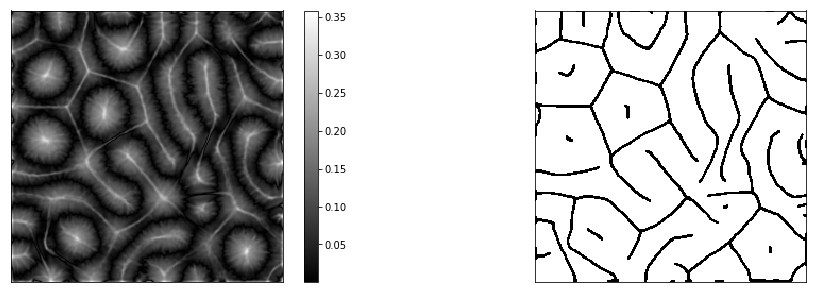

In [136]:
j=5
plt.figure(figsize=(17, 5))
plt.subplot(1, 2,1)
plt.imshow(images[j], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.subplot(1, 2,2)
plt.imshow(masks[j], cmap='gray')
plt.xticks([])
plt.yticks([])

## Data agumentation

We augment the data by rotating the images by 90 degrees and flipping it vertically, for a total of 8 augmented images per snapshot.

In [8]:
def flip_rotate(img):
    '''
    Takes an image and returns 8 images, rotated by 90 degrees and flipped
    
    Parameters:
    img: a single image as a numpy array
    
    Returns:
    8 images as numpy arrays roated and flipped
    '''
    
    return (img, np.rot90(img,1), np.rot90(img,2), np.rot90(img,3), np.flipud(img), 
            np.rot90(np.flipud(img),1), np.rot90(np.flipud(img),2), np.rot90(np.flipud(img),3))

In [9]:
def augment(images,image_size):
    '''
    Augment a series of images by rotating and vertically flipping them
    
    Parameters:
    imgages: a 3D numpy array with a series of n square images
    image_size: height/width of the image
    
    Returns:
    imgs: a 3D numpy array with a collection of 8n augmented images 
    '''  
    
    aug = 8
    imgs = np.zeros((len(images) * aug,image_size,image_size))
    for i in range(len(images)):
        add = aug*i
        (imgs[0+add,:,:],imgs[1+add,:,:],imgs[2+add,:,:],
         imgs[3+add,:,:],imgs[4+add,:,:], imgs[5+add,:,:],
         imgs[6+add,:,:],imgs[7+add,:,:]) = flip_rotate(images[i])
    return imgs

In [10]:
size_downsampled = 256
imgs = augment(images[:],size_downsampled)
msks = augment(masks[:],size_downsampled)
print(imgs.shape)
print(msks.shape)

(144, 256, 256)
(144, 256, 256)


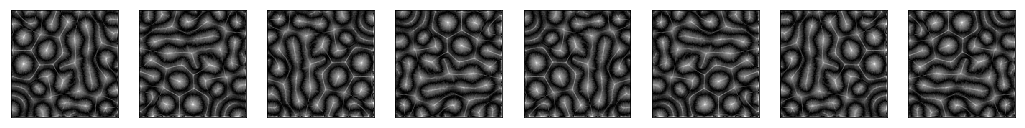

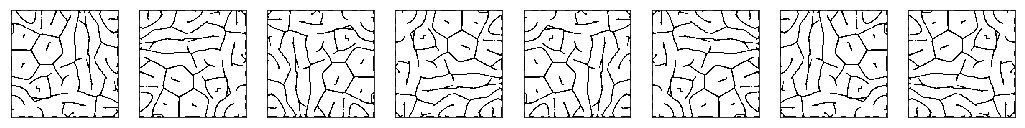

In [16]:
j=0
plt.figure(figsize=(18, 8))
for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.xticks([])
        plt.yticks([])
        im = plt.imshow(imgs[i + 8 * j,:,:], cmap='gray')       
plt.figure(figsize=(18, 8))
for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.xticks([])
        plt.yticks([])
        im = plt.imshow(msks[i + 8 * j,:,:], cmap='gray') 

## The U-net

We define the U-net model, with a total of 28 layers, as shown in the diagram below. As metric we define the intersection over union (iou).

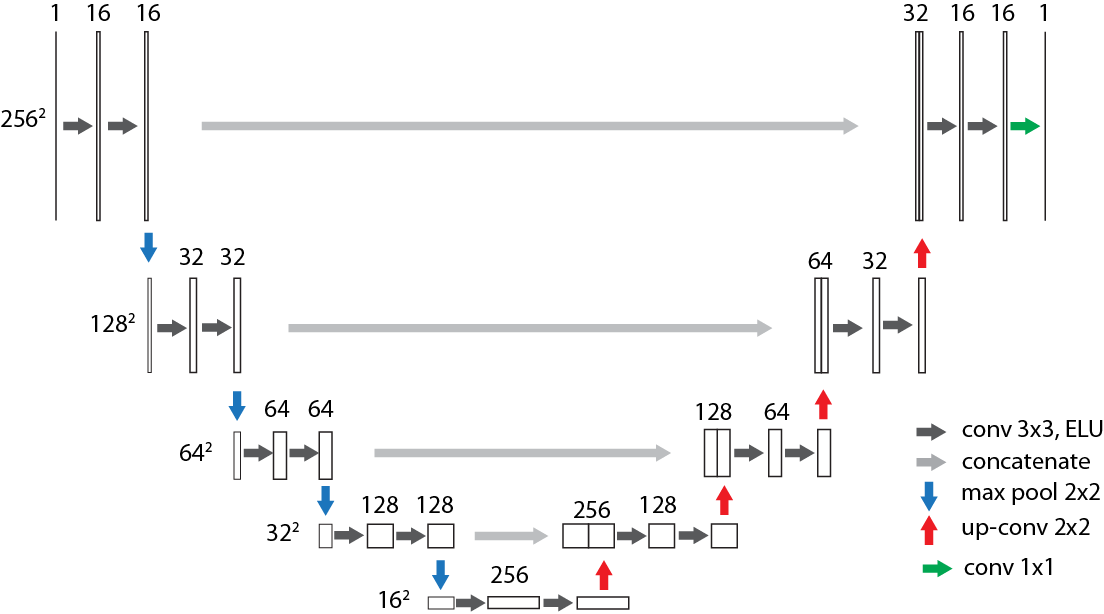

In [5]:
from IPython.display import Image
Image("U-net.png")

In [13]:
def iou(y_true, y_pred):
    '''
    Calculates the intersection over union (iou) between the predicted and true values 
    
    Parameters:
    y_true: true values
    y_pred: predicted values
    
    Returns:
    score: iou score
    '''
    
    y_pred_ = tf.to_int32(y_pred > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [14]:
inputs = Input((size_downsampled, size_downsampled, 1))
s = Lambda(lambda x: x / 1) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou,'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
X_train = imgs.reshape((imgs.shape[0],imgs.shape[1],imgs.shape[2], 1))
Y_train = msks.reshape((msks.shape[0],msks.shape[1],msks.shape[2], 1))
X_train.shape

(144, 256, 256, 1)

We fit the model and save its weights.

In [ ]:
%%time
earlystopper = EarlyStopping(patience=50, verbose=1)
checkpointer = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}-{val_acc:.3f}.h5', verbose=1, save_weights_only=True,  period=100)
results = model.fit(X_train, Y_train, validation_split=0.333, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

In [ ]:
model.save_weights('weights-u-net.h5')

In [20]:
model.load_weights('weights-u-net.h5', by_name=False)

## Benchmarking - iou

We calculate the intersection over union on 6 images with corresponding 6 masks manually traced.
The image on the top left is the symmetrized data, on the top right the mask, on the bottom left the output of the network, and on the bottom right the intersection (black) and union (black + gray) between the two.

In [151]:
imgstest = images[12:,:,:]
mskstest = masks[12:]

In [152]:
mskstest.shape

(6, 256, 256)

1/1 [==============================] - 0s 418ms/step
The average intersection over union is:  0.643


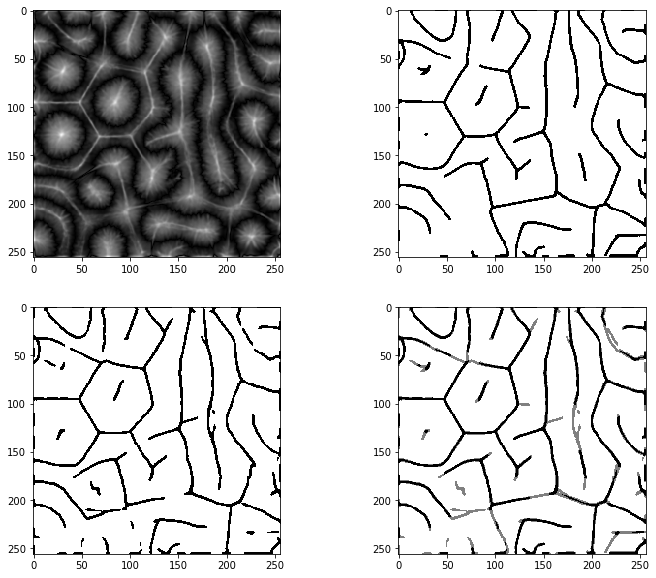

In [144]:
intersections = []
unions = []
for i,imgtest in enumerate(imgstest):
    preds_test = model.predict(imgtest.reshape((1,256,256, 1)), verbose=1)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    if i == 0:
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        plt.imshow(np.squeeze(imgstest[i]), cmap='gray')  
        plt.subplot(2, 2, 2)
        plt.imshow(np.squeeze(mskstest[i]), cmap='gray')
        plt.subplot(2, 2, 3)
        plt.imshow(np.squeeze(preds_test_t), cmap='gray')
        plt.subplot(2, 2, 4)
        summed = np.squeeze(mskstest[i])+np.squeeze(preds_test_t)
        plt.imshow(summed, cmap='gray')
    intersection = 256**2-np.count_nonzero(summed)
    union = sum(sum( summed < 2))
#     print('iou:  %.3f' % (intersection/union))
    intersections.append(intersection)
    unions.append(union)
    
    
print('The average intersection over union is:  %.3f' % (sum(intersections)/sum(unions)))

## Test data

We load the 848 snapshots of the test data.

In [145]:
size_img = 256
T_files = next(os.walk(path_t + '/avg_temp_pr7_ra1e5_848/'))[2]
if '.DS_Store' in T_files: 
    T_files.remove('.DS_Store')
images = np.zeros((len(T_files), size_img, size_img))
images_original = np.zeros((len(T_files), size_img, size_img)) 
for n,file_n in enumerate(T_files):
    if not file_n.startswith('.'):
#         print(file_n)
        img_linear = np.fromfile(path_t + '/avg_temp_pr7_ra1e5_848/' + file_n, dtype = np.dtype('<f8'))   
        img = np.reshape(img_linear,(256,256))
        img_original = copy.copy(img)
        img = np.absolute(img[:,:]-0.5)
        images[n] = img
        images_original[n] = img_original

Below one temperature snapshots with the original (unsymmetrized) data and the corresponding segmentation by the neural net.

1/1 [==============================] - 1s 1s/step


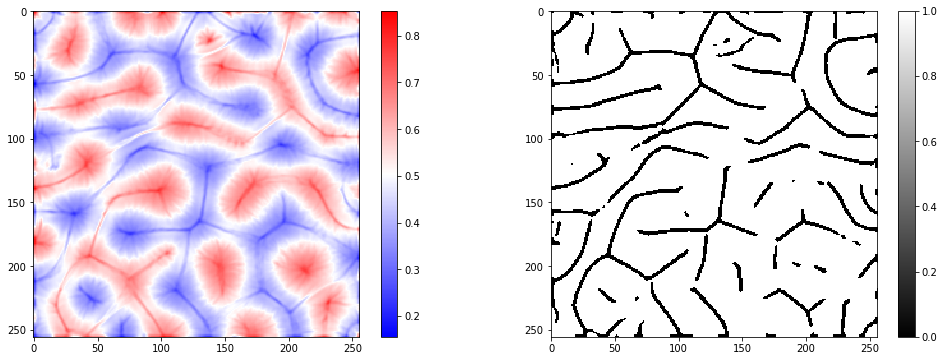

In [62]:
preds_test = model.predict(images[0].reshape((1,256,256, 1)), verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
plt.figure(figsize=(17, 6))
plt.subplot(1, 2,1)
plt.imshow(images_original[0], cmap='bwr')
plt.colorbar()
plt.subplot(1, 2,2)
plt.imshow(np.squeeze(preds_test_t), cmap='gray')
plt.colorbar()

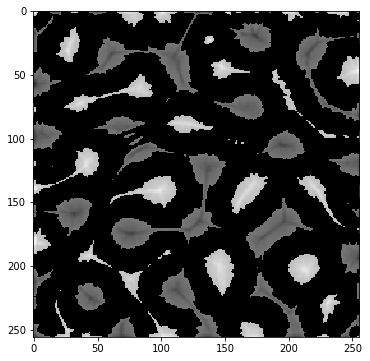

In [148]:
snapshot = images_original[0]
plt.figure(figsize=(17, 6))
plt.imshow(np.multiply(snapshot, snapshot>0.63)+np.multiply(snapshot, snapshot<0.4), cmap='gray')

## Defects detection

We define a series of fuctions with the goal of detecting defects, like wedges and trisectors.

In [71]:
def remove_duplicates(x_list,y_list):
    '''
    Takes a list of points, and returns a subset of these points, taking one point out of a group of adjacent points. 
    Used to remove duplicates of defects.
    
    Parameters:
    x_list: list of x values of the input points
    y_list: list of y values of the input points
    
    Returns:
    x_list_r: list of the x values of the output points
    y_list_r: list of the y values of the output points
    '''
    
    points_mask = np.zeros((256,256))
    
    for xx,yy in zip(x_list,y_list):
        points_mask[xx,yy] = 1
    labeled_points = measure.label(points_mask)
    n_points = np.max(labeled_points)
    
    x_list_r = []
    y_list_r = []
    for i in range(1,n_points + 1):
        x_list_r.append(np.where(labeled_points == i)[0][0])
        y_list_r.append(np.where(labeled_points == i)[1][0])
        
    return(x_list_r,y_list_r)  

In [70]:
def sub_images(image,x_list,y_list,image_size):
    '''
    Creates a collection of sub-images of a certain size around a list of points on a larger image.
    
    Parameters:
    image: image an numpy array
    x_list: list of x values of the input points
    y_list: list of y values of the input points
    image_size: size of the square sub-images
    
    Returns:
    sub_imgs: a numpy array with a collection of sub-images
    ''' 
    
    border = image_size//2
    sub_imgs = np.zeros((len(x_list),image_size,image_size)) + 1

    for i in range(len(x_list)):
        x = y_list[i]
        y = x_list[i]
        if (x > border) & (x < 256 - border) & (y > border) & (y < 256 - border):
            sub_imgs[i,:,:] = image[x - border : x + border, y - border : y + border]  
        
    return sub_imgs

In [69]:
def count_side_intersections(sub_imgs,image_size):
    '''
    Count the interesection of the black pixels on each side of the sub-images.  
    
    Parameters:
    sub_imgs: numpy array with a collection of sub-images
    image_size: length/width of each sub-image
    
    Returns:
    count: list of number of intersections (0-4) for each sub-image
    ''' 
    
    count = np.zeros(sub_imgs.shape[0])
    
    for j in range(sub_imgs.shape[0]):
        count[j] = 0
        if 0 in sub_imgs[j,:,image_size-1]:
            count[j] += 1
        if 0 in sub_imgs[j,:,:1]:
            count[j] += 1
        if 0 in sub_imgs[j,:1,:]:
            count[j] += 1
        if 0 in sub_imgs[j,image_size-1,:]:
            count[j] += 1
        if ((sub_imgs[j,0,0] == 0) or (sub_imgs[j,0,image_size-1] == 0) 
            or (sub_imgs[j, image_size - 1, 0] == 0) or (sub_imgs[j, image_size - 1, image_size - 1] == 0)):
            count[j] -= 1    
            
    return count

In [67]:
def find_defects(image):
    '''
    Returns the coordinates of the wedges and trisectors found in the image.  
    
    Parameters:
    image: a single image as a numpy array
    
    Returns:
    x_tri_rr: list of the x coordinates of the trisectors 
    y_tri_rr: list of the y coordinates of the trisectors 
    x_wed_rr: list of the x coordinates of the wedges 
    y_wed_rr: list of the y coordinates of the wedges 
    ''' 
    
    image = np.squeeze(image)
    all_labels = measure.label(-(image - 1))
    
    # remove section with less than 20 pixels
    to_remove = []
    for i in range(np.max(all_labels)):
        countpx = np.where(all_labels == i)[0].shape
        if countpx[0] < 20:
            to_remove.append(i)        
    for i in range(len(to_remove)): 
        image[all_labels == to_remove[i]] = 1       
            
            
    a = -(image - 1)
    n = 256
    nn = np.zeros((n, n))
    for j in range(2,n-2):
        for i in range(2,n-2):
            nn[i,j] = (+16*a[i+1,j]
                       +16*a[i-1,j]  
                       +16*a[i,j+1]   
                       +16*a[i,j-1]   
                       +8*a[i-1,j-1]  
                       +8*a[i-1,j+1]  
                       +8*a[i+1,j-1]  
                       +8*a[i+1,j+1]  
                       +4*a[i+2,j]    
                       +4*a[i-2,j]    
                       +4*a[i,j+2]    
                       +4*a[i,j-2]    
                       +2*a[i+2,j+1]  
                       +2*a[i+2,j-1]  
                       +2*a[i-2,j+1]  
                       +2*a[i-2,j-1]  
                       +2*a[i+1,j+2]  
                       +2*a[i-1,j+2]  
                       +2*a[i+1,j-2]  
                       +2*a[i-1,j-2]  
                       +a[i+2,j+2]  
                       +a[i+2,j-2]  
                       +a[i-2,j+2]  
                       +a[i-2,j-2])          
    
    threshold = 115
    x_tri = np.where(nn > threshold)[1]
    y_tri = np.where(nn > threshold)[0]

    
    threshold = 50
    x_list_w = np.where((nn < threshold) & (nn > 0))[1]
    y_list_w = np.where((nn < threshold) & (nn > 0))[0]
    
    set_low = set(zip(x_list_w,y_list_w))
    
    x_black = np.where(image == 0)[1]
    y_black = np.where(image == 0)[0]
    set_black = set(zip(x_black,y_black))
    
    x_wed = []
    y_wed = []
    inter_list = list(set_low.intersection(set_black))
    for i in range(len(inter_list)):
        x_wed.append(inter_list[i][0])
        y_wed.append(inter_list[i][1])
    
    x_tri_r,y_tri_r = remove_duplicates(x_tri,y_tri)
    x_wed_r,y_wed_r = remove_duplicates(x_wed,y_wed)
    
    image_size = 14
    sub_imgs_t = sub_images(image,x_tri_r,y_tri_r,image_size)
    sub_imgs_w = sub_images(image,x_wed_r,y_wed_r,image_size)
    
    count_t = count_side_intersections(sub_imgs_t,image_size)
    count_w = count_side_intersections(sub_imgs_w,image_size)
    
    to_remove = []
    for j in range(len(x_tri_r)):
        if count_t[j] < 3:
            to_remove.append(j)

    x_tri_rr = np.delete(x_tri_r,to_remove)
    y_tri_rr = np.delete(y_tri_r,to_remove) 
    
    to_remove = []
    for j in range(len(x_wed_r)):
        if count_w[j] > 1:
            to_remove.append(j)

    x_wed_rr = np.delete(x_wed_r,to_remove)
    y_wed_rr = np.delete(y_wed_r,to_remove) 
    
    
    return x_tri_rr, y_tri_rr, x_wed_rr, y_wed_rr
    

Example of defect detection on a snapshots.

In [77]:
x_tri, y_tri, x_wed, y_wed = find_defects(preds_test_t[0])

[]

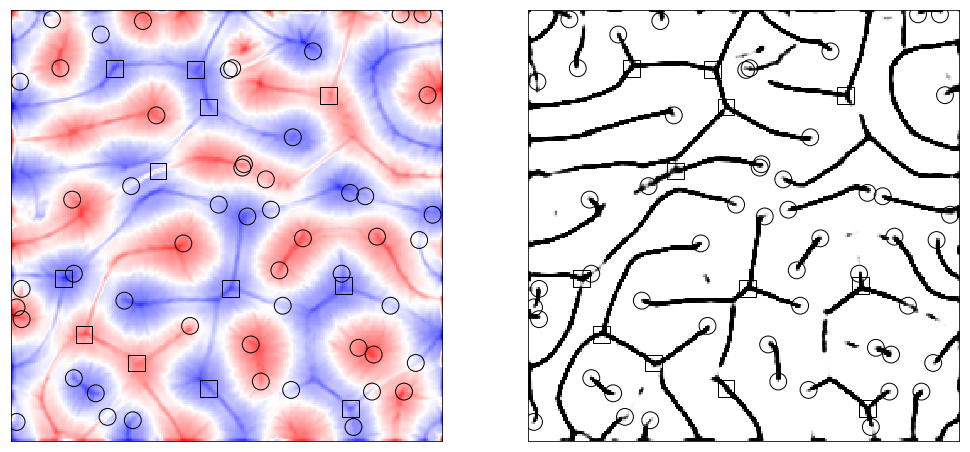

In [78]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))

ax1.imshow(images_original[0], cmap='bwr')

for xx,yy in zip(x_wed,y_wed):
    circ = plt.Circle((xx,yy),5,fill=False)
    ax1.add_patch(circ)
    
for xx,yy in zip(x_tri,y_tri):
    circ = plt.Rectangle((xx-5,yy-5),10,10,fill=False)
    ax1.add_patch(circ)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(np.squeeze(preds_test[0]), cmap='gray')

for xx,yy in zip(x_wed,y_wed):
    circ = plt.Circle((xx,yy),5,fill=False)
    ax2.add_patch(circ)
    
for xx,yy in zip(x_tri,y_tri):
    circ = plt.Rectangle((xx-5,yy-5),10,10,fill=False)
    ax2.add_patch(circ)
 
ax2.set_xticks([])
ax2.set_yticks([])

In [ ]:
def find_adjacency_weighted(image, x_tri_rr, y_tri_rr, x_wed_rr, y_wed_rr):
     '''
    Returns the weighted adjacency matrix of the graph associated with the defects.  
    
    Parameters:
    image: a single image an a numpy array
    x_tri_rr: list of the x coordinates of the trisectors 
    y_tri_rr: list of the y coordinates of the trisectors 
    x_wed_rr: list of the x coordinates of the wedges 
    y_wed_rr: list of the y coordinates of the wedges
    
    Returns:
    adjacency_weighted: adjacency matrix as a numpy array 
    ''' 
        
    image_conn = copy.copy(image)
    border = 4
    for j in range(len(y_tri_rr)):
        image_conn[y_tri_rr[j] - border : y_tri_rr[j] + border, x_tri_rr[j] - border : x_tri_rr[j] + border] = 1
    
    segments = measure.label(-(image_conn-1))
    x_points = np.array(list(x_tri_rr) + list(x_wed_rr))
    y_points = np.array(list(y_tri_rr) + list(y_wed_rr))
    
    adjacency_weighted = np.zeros((len(x_points),len(x_points)), dtype=np.uint32)
    for s in range(1,np.max(segments)):  
        segment = np.zeros((256,256), dtype=np.uint32)
        segment[np.squeeze(segments==s)] = 1
        border_e = border + 1
        x_list_seg = []
        y_list_seg = []
        point_id = [] 
        for j,_ in enumerate(x_points):    
            single_point=np.zeros((256,256), dtype=np.uint32)
            if y_points[j] - border_e >= 0:
                y_f = y_points[j] - border_e
            else:
                y_f = 0  
            if x_points[j] - border_e >= 0:
                x_f = x_points[j] - border_e
            else:
                x_f = 0   
            single_point[y_f:y_points[j] + border_e,
                         x_f:x_points[j] + border_e] = 1       
            if np.sum(single_point & segment) > 0:
                point_id.append(j)
                x_list_seg.append(x_points[j])
                y_list_seg.append(y_points[j])
        if len(point_id) > 1:
            dist = hypot(x_points[point_id[0]] - x_points[point_id[1]],
                         y_points[point_id[0]] - y_points[point_id[1]])
            adjacency_weighted[point_id[0],point_id[1]] = dist
            adjacency_weighted[point_id[1],point_id[0]] = dist
    return adjacency_weighted        

In [79]:
def find_laplacian(adjacency):
    '''
    Returns the laplacian of a graph given its adjacency matrix.  
    
    Parameters:
    adjacency: adjacency matrix as a numpy array
    
    Returns:
    laplacian: laplacian matrix as a numpy array 
    ''' 
    
    degree = np.zeros((adjacency.shape[0],adjacency.shape[0]), dtype=np.uint32)    
    for i,row in enumerate(adjacency):
        degree[i,i] = sum(row)
    degree = degree.astype(int)
    adjacency = adjacency.astype(int)
    laplacian = degree - adjacency
    return laplacian

In [ ]:
snapshots = 848
laplacians = []
adjacencies = []
n_sections = []
n_tri = []
n_wed = []
x_tri_list = []
y_tri_list = []
x_wed_list = []
y_wed_list = []
ridges = np.zeros((snapshots, size_img, size_img))
for i in range(snapshots):

    preds = model.predict(images[i].reshape((1,images.shape[1],images.shape[2], 1)), verbose=1)
    preds_t = (preds > 0.5).astype(np.uint8)
    ridges[i] = np.squeeze(preds_t)
    n_sections.append(np.max(measure.label(-(preds_t[0] - 1))))
    x_tri_rr, y_tri_rr, x_wed_rr, y_wed_rr = find_defects(preds_t[0])
    print('snapshots:', i, '- trisectors:', len(x_tri_rr), '- wedges:', len(x_wed_rr))
    n_tri.append(len(x_tri_rr))
    n_wed.append(len(x_wed_rr))
    x_tri_list.append(x_tri_rr)
    y_tri_list.append(y_tri_rr)
    x_wed_list.append(x_wed_rr)
    y_wed_list.append(y_wed_rr)
    adjacency_weighted = find_adjacency_weighted(preds_t[0], x_tri_rr, y_tri_rr, x_wed_rr, y_wed_rr)
    laplacians.append(find_laplacian(adjacency))
    adjacencies.append(adjacency_weighted)

In [ ]:
# file_Name = 'tri_wed_10^5_r=.pckl'
# tri_wed = [x_tri_list,y_tri_list,x_wed_list, y_wed_list]
# fileObject = open(file_Name,'wb') 
# pickle.dump(tri_wed,fileObject)   
# fileObject.close()

In [ ]:
# file_Name = 'ridges_10^5_r.pckl'
# fileObject = open(file_Name,'wb') 
# pickle.dump(ridges,fileObject)   
# fileObject.close()

In [ ]:
# file_Name = 'adjacency_10^5_r=.pckl'
# fileObject = open(file_Name,'wb') 
# pickle.dump(adjacencies,fileObject)   
# fileObject.close()

In [85]:
[x_tri_list,y_tri_list,x_wed_list, y_wed_list] = pickle.load( open( 'tri_wed_10^5_r.pckl', 'rb' ) )

In [86]:
ridges = pickle.load( open( 'ridges_10^5_r.pckl', 'rb' ) )

Each snapshot is separated by 2.5 free-fall times.

In [87]:
Tf = (np.array(range(848)) + 1) * 2.5

Weshow the variability of the number of trisector and wedges over the whole 848 snapshots.

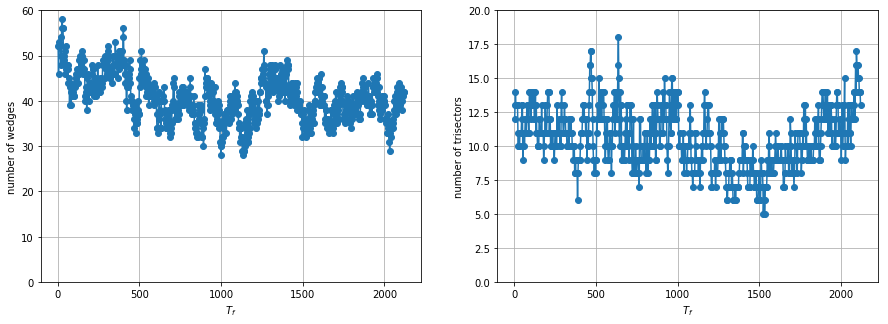

In [108]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(Tf, [len(x) for x in x_wed_list], 'o-')
plt.ylabel("number of wedges")
plt.xlabel('$T_f$')
plt.ylim(0,60)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(Tf, [len(x) for x in x_tri_list], 'o-')
plt.ylabel("number of trisectors")
plt.xlabel('$T_f$')
plt.ylim(0,20)
plt.grid(True)

## Heat transfer data

In [149]:
heat_files = next(os.walk(path_t + '/avg_uzth_ra1e5/'))[2]
size_heat = 256
heat = np.zeros((len(heat_files), size_heat, size_heat))
for n,file_n in enumerate(heat_files):
    if not file_n.startswith('.'):
#         print(file_n)
        heat_linear = np.fromfile(path_t + '/avg_uzth_ra1e5/' + file_n, dtype = np.dtype('<f8'))
        heat_img = np.reshape(heat_linear,(256,256))
        heat[n] = heat_img

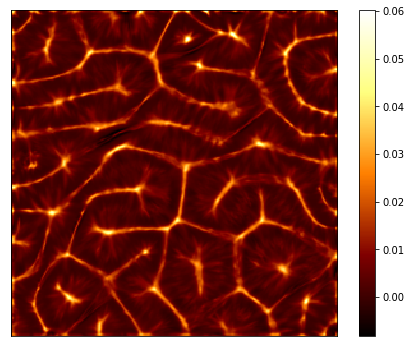

In [84]:
plt.figure(figsize=(8, 6))
plt.imshow(heat[1], cmap='afmhot')
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [102]:
Nu_prop = np.sqrt(7*10**5)
Nu = []
Nu_rid = []
tri_val = []
wed_val = []
tri_avg_list = []
wed_avg_list = []
rid_avg_list = []
area_rid = []
for i in range(848):
    
    area_rid.append(np.sum(ridges[i] == 0))
    for j in range(len(x_tri_list[i])):
        tri_val.append(heat[i][y_tri_list[i][j]][x_tri_list[i][j]])
    tri_avg = np.mean(tri_val)
    tri_avg_list.append(tri_avg)
    
    for j in range(len(x_wed_list[i])):
        wed_val.append(heat[i][y_wed_list[i][j]][x_wed_list[i][j]])
    wed_avg = np.mean(wed_val)
    wed_avg_list.append(wed_avg)
    
    rid = abs(ridges[i] - 1)
    mask = np.ma.make_mask(rid)
    rid_avg = np.mean(heat[i][mask])
    rid_avg_list.append(rid_avg)
    
    avg = np.mean(heat[i])
    fraction_area_rid = area_rid[i] / 256**2
    Nu.append(Nu_prop*np.mean(heat[i]))
    Nu_rid.append(Nu_prop*fraction_area_rid*rid_avg)

We show average Nusselt number, and the local Nusselt number on trisector, wedges and ridges.

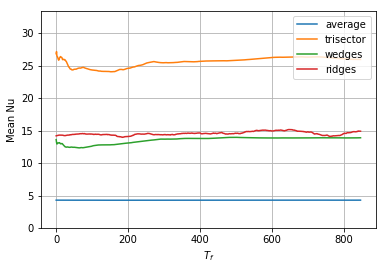

In [153]:
Nu_prop = np.sqrt(7*10**5)
plt.plot(Nu, label="average")
plt.plot(Nu_prop*np.array(tri_avg_list), label="trisector")
plt.plot(Nu_prop*np.array(wed_avg_list), label="wedges")
plt.plot(Nu_prop*np.array(rid_avg_list), label="ridges")
plt.ylim(0,0.040*Nu_prop)
plt.ylabel('Mean Nu')
plt.xlabel('$T_f$')
plt.grid(True)
plt.legend()

We show the area fraction of the ridges over the whole area, and the contribution to the ridges on the total heat flux.

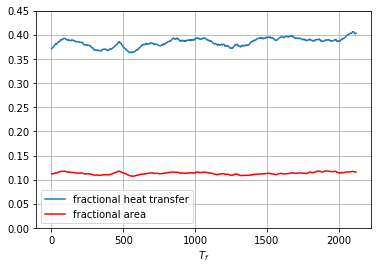

In [104]:
plt.plot(Tf, np.array(Nu_rid)/np.array(Nu), label = 'fractional heat transfer')
plt.plot(Tf, np.array(area_rid)/256**2, label = 'fractional area',color = 'r')
plt.ylim(0,0.45)
plt.xlabel('$T_f$')
plt.grid(True)
plt.legend()